In [1]:
############################
###### Initialisation ######
############################

import pandas as pd
from utils.utils import get_energy_type, pivot_dates, CountryTranslatorFrenchToEnglish, GroupMaker
from utils.format import StatisticsDataframeFormatter
import os

PATH_MAIN = r'C:\Users\Cheri\Desktop\Data for Good\Shift Data Portal\sdp_git - Copie\shiftdataportal\data-preparation\src'
PATH_ELECTRICITY_DATA = r'C:\Users\Cheri\Desktop\Data for Good\Shift Data Portal\data\data_2023_qua.csv'
PATH_COUNTRIES = 'country_groupss.csv'
EXPORT_PATH = r'C:\Users\Cheri\Desktop\Data for Good\Shift Data Portal\sdp_git - Copie\shiftdataportal\data-preparation\data\new_prod_data\WORLD_ENERGY_HISTORY_electricity_capacity_prod.csv'

os.chdir(PATH_MAIN)


######################################################
###### Chargement et Transformation des données ######
######################################################


### Data loading 
data = pd.read_csv(PATH_ELECTRICITY_DATA, skiprows=1)

# Importing the country groups table
countries = pd.read_csv(PATH_COUNTRIES)


############ Data Transformation ############

### Energy Type
data = get_energy_type(data)

### Pivoting table
data = pivot_dates(data)

### Country Translation
data['country'] = CountryTranslatorFrenchToEnglish().run(serie_country_to_translate=data['country'], 
                                                         raise_errors=True)

# Adding groups to dataset
data = GroupMaker(data, countries)
data = data[data['country']!="Delete"].drop_duplicates()

# Adding the context columns
data['source'] = 'US EIA'
data['unit'] = 'GW'

# Dataframe ordering
data = data[["source", "group_type", "country", "year", "energy_family", "power", "unit"]]

# Formating the dataset
data = StatisticsDataframeFormatter.select_and_sort_values(df=data, 
                                                           col_statistics='power')

#####################################
###### Testing and data export ######
#####################################

# Testing for missing values
assert data.isna().sum().sum() == 0, "Missing values are present in the final dataset." 

# Exporting to csv
#data.to_csv(EXPORT_PATH, index=False)

Merge tests : OK


c:\Users\Cheri\Desktop\Data for Good\Shift Data Portal\sdp_git - Copie\shiftdataportal\data-preparation\src\utils\utils.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table['energy_family'] = np.select([table['energy_family'].str.contains("biomass and waste"),


## Data validation


Nombre d'entrées de l'ancienne base : 47890
Nombre d'entrées de l'ancienne base : 59266
Part of differences between old and new values : 61.77%
Mean of differences between old and new values (%) : 33.26%
Number of updated observations (from zeros) : 815 entries


,group_name,year,energy_family,power_old,power_new,is_equal,power_diff
46110,Eurasia,2000,Biomass and Waste,0.001,1.2474,0,1246.400000
46118,Eurasia,2001,Biomass and Waste,0.004,1.2917,0,321.924992
24548,Malawi,2010,Fossil Fuels,0.001,0.2119,0,210.900000
46126,Eurasia,2002,Biomass and Waste,0.011,1.2717,0,114.609088
24572,Malawi,2013,Fossil Fuels,0.002,0.2119,0,104.949995


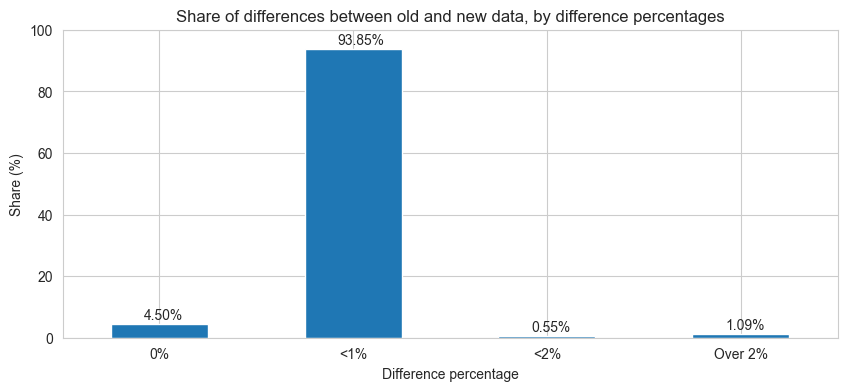

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings

warnings.filterwarnings('ignore')

sns.set_style("whitegrid")

OLD_DATA_PATH = r'C:\Users\Cheri\Desktop\Data for Good\Shift Data Portal\data\data_2016.csv'
NEW_DATA_PATH = r'C:\Users\Cheri\Desktop\Data for Good\Shift Data Portal\sdp_git - Copie\shiftdataportal\data-preparation\data\new_prod_data\WORLD_ENERGY_HISTORY_electricity_capacity_prod.csv'

# Loading
old_data = pd.read_csv(OLD_DATA_PATH)
new_data = pd.read_csv(NEW_DATA_PATH)

print(f"Nombre d'entrées de l'ancienne base : {old_data.shape[0]}")
print(f"Nombre d'entrées de l'ancienne base : {new_data.shape[0]}")

# Merging
data = pd.merge(new_data, old_data, how='inner', on=["group_name", "year", "energy_family"], suffixes=("_new", "_old"))
data = data[['group_name', 'year', 'energy_family', 'power_old', 'power_new']]

# Equality Checking
data['is_equal'] = np.where(data['power_new'] == data['power_old'], 1, 0)
print(f"Part of differences between old and new values : {data['is_equal'].mean():.2%}")

# Difference Checking
data['power_diff'] = np.where(data['power_old'] != 0, np.absolute((data['power_new'] - data['power_old']) / data['power_old']), 0)
print(f"Mean of differences between old and new values (%) : {data[data['is_equal']==0]['power_diff'].mean():.2%}")

# Data update (from 0)
zeros = data[(data['power_old'] == 0)&(data['power_new']!=0)]
print(f'Number of updated observations (from zeros) : {zeros.shape[0]} entries')

display(data.sort_values("power_diff", ascending=False).head(5))

# Difference Groups
differences = data[data['is_equal'] == 0]
differences['power_diff'] = differences['power_diff'].apply(math.ceil)
differences['power_diff'] = np.select([differences['power_diff'] == 0,
                                      differences['power_diff'] < 3],
                                      
                                      ["0%", "<" + differences['power_diff'].astype(str) + "%"],
                                      
                                      "Over 2%")

data_plot = (differences['power_diff'].value_counts(normalize=True)).reindex(["0%", "<1%", "<2%", "Over 2%"])

# Plot Options

data_plot.plot(kind='bar', figsize=(10,4), rot=0)

data_plot_df = pd.DataFrame(data_plot)


xs = [i for i in range(len(data_plot_df))]
ys = [i for i in data_plot_df['proportion']]
texts = [f'{i:.2%}' for i in data_plot_df['proportion']]

for x, y, text in zip(xs, ys, texts):
    plt.text(x-0.08, y+0.015, text)

plt.title('Share of differences between old and new data, by difference percentages')
plt.xlabel('Difference percentage')
plt.ylabel('Share (%)')
plt.yticks(ticks=[i/100 for i in range(0, 101, 20)], labels=[i for i in range(0, 101, 20)]);